In [2]:
import matplotlib.pyplot as plt
import numpy as np

from matplotlib.colors import LogNorm
import copy

# Fixing random state for reproducibility
np.random.seed(19680801)

In [26]:
s_start = 20
s_end = 40
N_start = 2**10
N_end = 2**30

s_steps = 20 
N_steps = 20
ds = (s_end - s_start) / s_steps
dN = (N_end - N_start) / N_steps


k = 1000
epsilon = 0.01
bits = 10


s, N = np.mgrid[s_start * ds:s_end *ds:ds, N_start:N_end:dN]
# N = 2**base

# print(base.shape)
# s = np.mgrid[start * ds: end * ds + ds: ds]
# n = np.mgrid[start * dn: end * dn + dn: dn]
# print(n.shape)
# print(n)

# quantum volume
nhs = np.sqrt(80 / 3) * np.pi * k**2 * s / epsilon**2
q_alg_phs = bits + 2 * np.log2(N) + 2
q_lgc_phs = 2 * q_alg_phs + np.ceil(np.sqrt(8 * q_alg_phs)) + 1
log_depth_phs = 10 * np.log2(N) + 609
volumn = nhs * q_lgc_phs * log_depth_phs

# dN = 
# N = np.mgrid[]
# # Create meshgrid for s and N
# startN = 
# maxN = 2**(end)
# dN = (maxN - minN) / (end - start)
# s, N = np.mgrid[start * ds: end * ds + ds: ds, minN: maxN: dN]

# # Calculate the classical flops
flops = 0.5 * k * np.log(2 / epsilon) * (4 * N * s + 14 * N)


# Calculate the ratio classical / quantum
# ratio = np.empty_like(N)
# for i in range(N.shape[0]):
#     for j in range(N.shape[1]):
#         c_n = (np.floor(np.log2(N[i,j])) - start  - 1).astype(int)
#         ratio[i, j] =  
fig, axs = plt.subplots(1,2, figsize=(15, 5), gridspec_kw={'width_ratios': [1, 1]})

all_min = min(np.min(volumn), np.min(flops))
all_max = max(np.max(volumn), np.max(flops))
ax = axs[0]
c = ax.pcolor(N, s, volumn, cmap='RdBu', vmin=all_min, vmax=all_max)
ax.set_title('quantum volume')
fig.colorbar(c, ax=ax)


ax = axs[1]
c = ax.pcolor(N, s, flops, cmap='RdBu', vmin=all_min, vmax=all_max)
ax.set_title('classical flops')
fig.colorbar(c, ax=ax)

# ax = axs[2]
# c = ax.pcolor(N, s, diff, cmap="bwr", vmin=diff_min, vmax=diff_max)
# ax.set_title("classical - quantum")
# fig.colorbar(c, ax=ax)

plt.tight_layout()
plt.show()

(20, 20)


## Logical Volumn

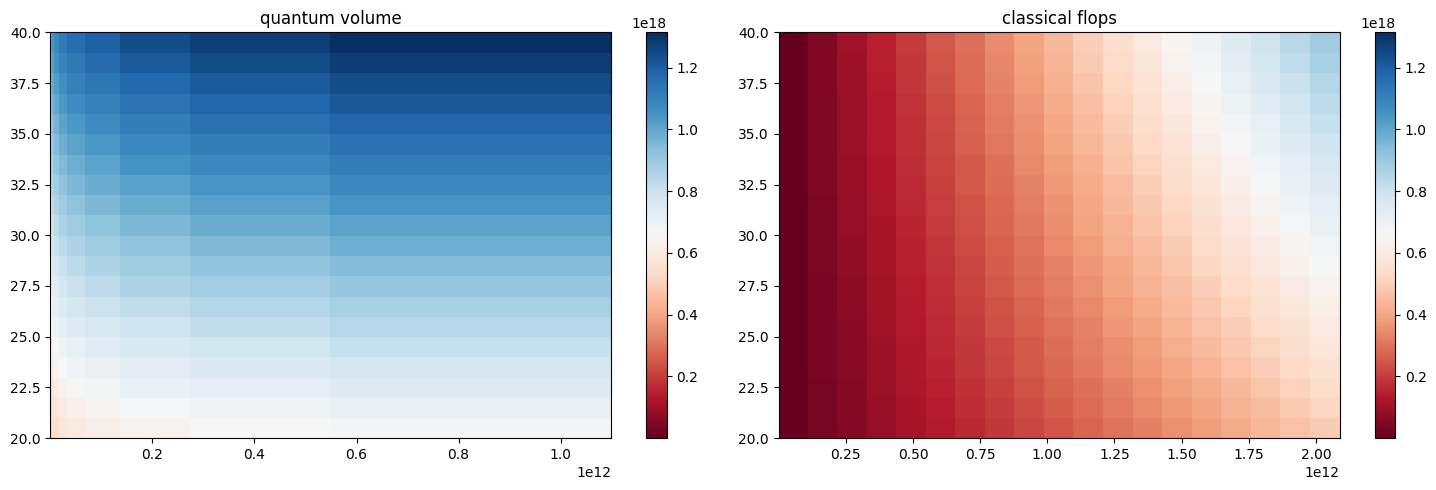

In [16]:
# diff = copy.deepcopy(flops)

# for i in range(sap_range):
#     for j in range(sap_range + 1):
#         # print(np.ceil(np.log2(N[i,j])))
#         diff[i, j] = diff[i,j] - volumn[i, (np.floor(np.log2(N[i,j])) - start  - 1).astype(int)]
# diff_min, diff_max = diff.min(), diff.max()

all_min = np.min([volumn_min, flops_min])
all_max = np.max([volumn_max, flops_max])

# print("volumn_min", volumn_min)
# print("volumn_max", volumn_max)
# print("flops_min", flops_min)
# print("flops_max", flops_max)

# 创建一个单独的子图
fig, axs = plt.subplots(1,2, figsize=(15, 5), gridspec_kw={'width_ratios': [1, 1]})

# 使用 pcolor 绘制
ax = axs[0]
expn = 2**n
c = ax.pcolor(expn, s1, volumn, cmap='RdBu', vmin=all_min, vmax=all_max)
ax.set_title('quantum volume')
fig.colorbar(c, ax=ax)


ax = axs[1]
c = ax.pcolor(N, s, flops, cmap='RdBu', vmin=all_min, vmax=all_max)
ax.set_title('classical flops')
fig.colorbar(c, ax=ax)

# ax = axs[2]
# c = ax.pcolor(N, s, diff, cmap="bwr", vmin=diff_min, vmax=diff_max)
# ax.set_title("classical - quantum")
# fig.colorbar(c, ax=ax)

plt.tight_layout()
plt.show()

## Runtime

(28, 28)


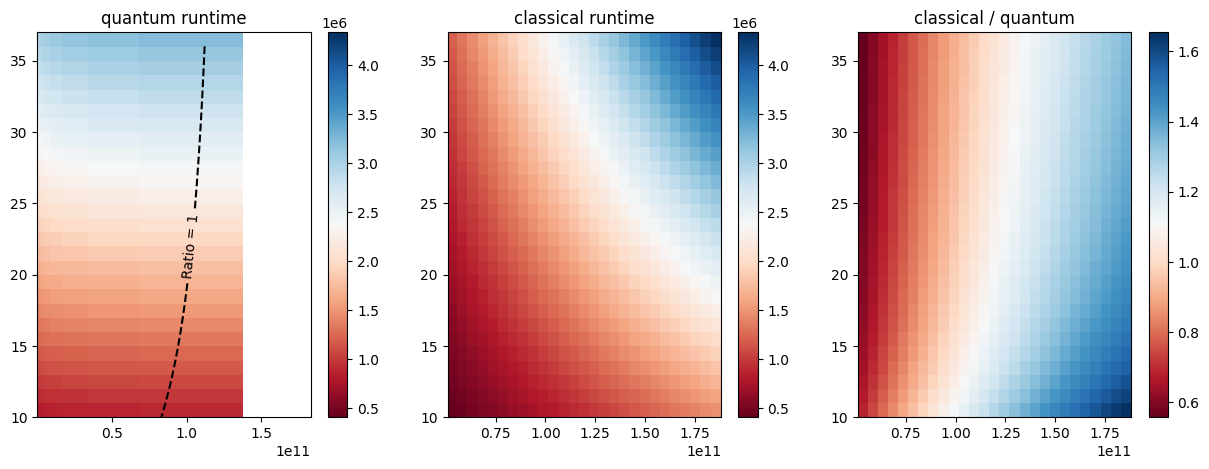

In [ ]:
# This can easily be replaced by 3000000 + 70000*n
# with open("hsruntimes.json", "r") as file:
#     hsruntimeslist = json.load(file)
#     hsruntimes = np.array(hsruntimeslist)

start = 10
sap_range = 27

# truncated_hsruntimes = hsruntimes[start: start + sap_range]


k = 100
epsilon = 0.1


ds = 1
dn = 1 # dimension equasion 2^n

bits = 10

s1, n = np.mgrid[start *ds: (start + sap_range) * ds + ds : ds, start *dn : (sap_range + start) * dn + dn : dn]
# the number of hamiltonian simulation
# here we assume that the one sparese decomposition is optimal, and
# is done in the application level, so the dependence on s
# is s, and there is no graph coloring cost for each hamiltonian simulation
nhs = np.sqrt(80 / 3) * np.pi * k**2 * s1 / epsilon**2 # number of hamiltonian simulation
nhs = nhs[:-1, :-1]
n_cut = n[:-1, :-1]
qruntime = nhs * (3000000 + 70000*n_cut)  / 1e9 # change runtime from nanoseconds to seconds


# print(runtime.max() / 1e9)
# print(nhs)
# print("runtime: \n\n\n\n\n")
# print(runtime)
maxN = 2**(start  + sap_range)
minN = 2**start
dN = maxN / sap_range
s, N = np.mgrid[start*ds : (start + sap_range) * ds + ds : ds, start * dN : (start + sap_range) * dN + dN : dN]
flops = 1 / 2 * k * np.log(2 / epsilon) * (4 * N * s + 14 * N)
flops = flops[:-1, :-1]
flops_min , flops_max = flops.min(), flops.max()
cruntime = flops / 1e9 # assume 1GFLOPS


ratio = cruntime / qruntime

all_min = np.min([qruntime.min(), cruntime.min()])
all_max = np.max([qruntime.max(), cruntime.max()])


fig, axs = plt.subplots(1,3,figsize=(15, 5))
ax = axs[0]
# 使用 pcolor 绘制
expn = 2**n
c = ax.pcolor(expn, s1, qruntime, cmap="RdBu", vmin=all_min, vmax=all_max)
ax.set_title("quantum runtime")
fig.colorbar(c, ax=ax)


# print(expn.shape)
# print(s1.shape)

contour = ax.contour(
    N[:-1, :-1],
    s1[:-1, :-1],
    ratio,
    levels=[1],
    colors="black",
    linewidths=1.5,
    linestyles="--",
)
ax.clabel(contour, fmt="Ratio = 1", colors="black")

ax = axs[1]
# 使用 pcolor 绘制
c = ax.pcolor(N, s1, cruntime, cmap="RdBu", vmin=all_min, vmax=all_max)
ax.set_title("classical runtime")
fig.colorbar(c, ax=ax)


ax = axs[2]
# 使用 pcolor 绘制
c = ax.pcolor(N, s1, ratio, cmap="RdBu", vmin=ratio.min(), vmax=ratio.max())
ax.set_title("classical / quantum")
fig.colorbar(c, ax=ax)
#